# Notebook for Regression Question for CUTE 2

### @Authors : Karthik, Kiran and Shubham

### Introduction
In this notebook we present an approach to solve the regression challange for data regarding the amount a customer spends in a given chain to retail store. The target variable is Amount.
Here we focus more on Exploratory Data Analysis, Feature Engineering and linear models.
While other models have been built they are used only as benchmark with the default parameters i.e. without any hyper parameter tuning.
The error metrics used throught this notebook are Root Mean Squared Error(RMSE) and Mean Absolute Percent Error (MAPE) .
A combination of RMSE and MAPE gives a real picture of the error we are making

# Importing Packages

Import required packages for Exploratory Data Analysis (EDA), data manipluation and statistics

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

from statistics import stdev
import math
from scipy import stats
from operator import add
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

Igonre all warnings generated by seaborn and other packages

In [2]:
import warnings
warnings.filterwarnings('ignore')

Import packages requried for data pre-processing

In [3]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from fancyimpute import KNN
from sklearn import feature_selection
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, make_scorer

Using TensorFlow backend.


Import packages required for Model building

In [4]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LinearRegression
import sklearn.ensemble 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor

# Data Manipulation

Read the data and make a copy of it so that we can restore any changes made to the dataframe

In [5]:
data = pd.read_csv('retail_train.csv')
data_copy = data.copy()
data.head()

PersonID  Amount  FamilySize  Distance  Duration  DirectVisits  \
0    C1104    3125           2         6       261            11   
1    C1111    5298           2         5       323             9   
2    C1117    4375           2         6       355            11   
3    C1128    9700           5         7       418            51   
4    C1132    3625           2         7       290             9   

   OnlineVisits  Quantity  NumberofFrequentItems  TransactionMode   Area  \
0             9       365                     11                2  Area1   
1             9       218                      3                2  Area1   
2            11      1367                     11                2  Area1   
3            41      2947                     51                1  Area1   
4             9      1233                      8                2  Area1   

   Occupation  
0           2  
1           1  
2           2  
3           1  
4           3

Since the PersonId column is unique for all rows the model does not get any information from it. Therefore, we drop it. Before droping the ID we should make a copy of it so that if we ever find any outliers or interesting cases we can ask the cilent to cross check by providing the Id. Also, ID would be required if we want to make predictions and send the predictions back to client.

In [6]:
print("The train data size before dropping PersonID feature is : {} ".format(data.shape))

#Save the 'PersonID' column
data_ID = data['PersonID']

#Now drop the  'PersonID' colum since it's unnecessary for  the prediction process.
data.drop("PersonID", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping PersonID feature is : {} ".format(data.shape)) 

The train data size before dropping PersonID feature is : (2938, 12) 

The train data size after dropping PersonID feature is : (2938, 11) 


Check the summary statistics of the data to get an overview of data

In [7]:
data.describe(include='all')

Amount  FamilySize  Distance  Duration  DirectVisits  OnlineVisits  \
count   2938.000    2938.000  2938.000  2938.000      2938.000      2938.000   
unique       nan         nan       nan       nan           nan           nan   
top          nan         nan       nan       nan           nan           nan   
freq         nan         nan       nan       nan           nan           nan   
mean    4209.432       3.116     7.354   349.147        16.283        14.745   
std     2069.917       1.039     2.989    89.622         8.495         7.311   
min     2500.000       2.000     3.000   100.000         1.000         1.000   
25%     2897.250       2.000     6.000   305.000        11.000        10.000   
50%     3512.000       3.000     7.000   368.000        14.000        13.000   
75%     4772.500       4.000     8.000   418.000        19.000        17.000   
max    24764.000      12.000    23.000   472.000       119.000       112.000   

        Quantity  NumberofFrequentItems  TransactionMode   Area  Occupation  
count   2938.000               2938.000         2938.000   2938    2938.000  
unique       nan                    nan              nan      2         nan  
top          nan                    nan              nan  Area1         nan  
freq         nan                    nan              nan   2600         nan  
mean    1600.155                 14.780            1.822    NaN       2.046  
std     1920.047                  8.823            0.383    NaN       0.818  
min        0.000                  0.000            1.000    NaN       1.000  
25%      444.000                 10.000            2.000    NaN       1.000  
50%     1028.500                 13.000            2.000    NaN       2.000  
75%     2047.250                 19.000            2.000    NaN       3.000  
max    27829.000                115.000            2.000    NaN       3.000

From the above results we see that Quantity and NumberofFrequentItems is 0 for some cases. We also see that minimum quantity is not 0 therefore, we conclude that these are actually missing values as we cannot have 0 quantity but some amount paid.
NumberoFrequentItems can be 0, but it depends on how the system calculates this column. Depending on that we will have to check each instance of 0 and decide if it is a missing value or not

Check how many rows have Quantity 0 and how many rows have NumberofFrequentItems 0

In [8]:
no_quantity = data.loc[data['Quantity']==0]
no_freq_items = data.loc[data['NumberofFrequentItems']==0]
print("Number of rows with 0 Quantity is : {} ({:.4f})".format(len(no_quantity), len(no_quantity)/data.shape[0]))
print("Number of rows with 0 NumberofFrequentItems is : {} ({:.4f}) ".format(len(no_freq_items),len(no_freq_items)/data.shape[0]))

Number of rows with 0 Quantity is : 32 (0.0109)
Number of rows with 0 NumberofFrequentItems is : 71 (0.0242) 


We see that there are not too many of these rows (1.1% and 2.4% respectively).
Since we do not have the knowledge of how exactly NumberofFrequentItems is calculated we have assumed all 0 values are actually missing values

Replace all 0's in Quantity and NumberofFrequentItems with np.nan

In [9]:
cols = ['Quantity','NumberofFrequentItems']
data[cols] =data[cols].replace({0:np.nan})

In the data we have some numeric data which is actually categorical namely, TransactionMode and Occpuation.
We have also assumed that for the inital data we will take FamilySize as categorical as there are not too many levels to it. 

In [10]:
cat_labels = ['FamilySize','Occupation','TransactionMode']
for label in cat_labels:
    data[label] = data[label].astype('str')

Now, let's check for any missing values in the data

In [11]:
print(data.isna().sum())

Amount                    0
FamilySize                0
Distance                  0
Duration                  0
DirectVisits              0
OnlineVisits              0
Quantity                 32
NumberofFrequentItems    71
TransactionMode           0
Area                      0
Occupation                0
dtype: int64


There is no missing value other than the ones we have converted for Quantity and NumberofFrequentItems

## Imputation

The way we have imputed the data is that first we consider the data without any NA's and then we randomly sample some rows and make the columns NA after a copy of this sample is made. Then we impute these samples and compare it to the copy made in order to get the an error metric (RMSE,MAPE) for the imptation strategy chosen.
This is done for two reasons:
1. To check how much error we are introducing in data after imputation
2. To decide which imputation technique is better for a given column so that we can impute different columns with different strategies.

The strategies chosen are:
1. Mean Imputation
2. Median Imputation
3. Knn imputation with k values 1,3,5,7,9,11,13,15,17,19
All of the errors are cross validated to give a robust error metric
The final errors for all strategies is stored in a dataframe so that we can see all errors at one glance

We define the error metrics RMSE(Root Mean Squared Error) and MAPE(Mean Absolute Percent Error)

In [12]:
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))
def rmse(y_true, y_pred):
    return  math.sqrt(mean_squared_error(y_true, y_pred))

The following fucntion imputes using the 2 central imputation strategies, Mean and Median.
For central imputation since not much computation is required we can dynamically calculate K for KFold Cross Validation.
For example if there is 2% of NA in data we can do a 100 / 2 = 50 fold cross validation. So that each row is taken as a sample, imputed and error is calucalted. We take a mean of all 50 errors.

In [13]:
def central_impute(strategy, filled, na_percent, target):
    ''' Select row on the basis of percent of missing values given so that each row is selected to be missing and is imputed. Error is calculated for all thes folds and a mean is taken.
    @params : 
        - strategy : To choose between 2 strategies Mean and Median (String)
        - filled : A pandas dataframe with no NA's
        - na_percent : Percentage of missing values in original data. Used to calculate value of K for KFold.
        - target : The target column which has to be imputed
    @returns :
        - A list of error metrics containing mean, standard deviation, minimum and maximum of both RMSE and MAPE   
    '''
    impute_rmse = []
    impute_mape = []
    na_quantity = math.ceil(filled.shape[0] * na_percent / 100)
    filled = filled.sample(frac = 1) # Shuffle the data
    filled.index = list(range(filled.shape[0]))
    original_filled = filled.copy()
    imputation_index = range(na_quantity)
    k_fold = math.ceil(filled.shape[0] / na_quantity)
    for i in range(1,k_fold):
        target_copy = filled.loc[imputation_index,target].copy()
        filled.loc[imputation_index,target] = np.nan
        if strategy == 'mean':
            filled[target] = filled[target].fillna(filled[target]).mean()
        if strategy == 'median':
            filled[target] = filled[target].fillna(filled[target]).median()
        impute_rmse.append(rmse(target_copy, filled.loc[imputation_index,target]))
        impute_mape.append(mape(target_copy, filled.loc[imputation_index,target]))
        filled = original_filled.copy()
        if i != k_fold-1:
            imputation_index = [x+na_quantity for x in imputation_index]
        else:
            imputation_index = range(max(imputation_index),filled.shape[0])
    return [strategy, np.mean(impute_rmse), stdev(impute_rmse), min(impute_rmse), max(impute_rmse),
            np.mean(impute_mape), stdev(impute_mape),min(impute_mape), max(impute_mape)]

Function for KNN imputation using FacnyImpute. 
As there is a lot of computation required for KNN we cannot take KFold value dynamically. Instead we supply a fix number of K.
Here the sample is taken randomly

In [14]:
def knn_impute_cv(filled,target,na_percent,k,cv,standardize_labels):
    ''' Standarize data, randomly take sample of data, replace with NA, impute, calculate the error for all thes folds and take a mean.
    @params : 
        - filled : A pandas dataframe with no NA's
        - target : The target column which has to be imputed
        - na_percent : Percentage of missing values in original data. Used to calculate value of K for KFold.
        - k : Number of nearest neighbours
        - cv : Cross validation K value
        - standardize_labels : Column names which have to be standarized
        
    @returns :
        - A list of error metrics containing mean, standard deviation, minimum and maximum of both RMSE and MAPE   
    '''
    sc = StandardScaler()
    filled[standardize_labels] = sc.fit_transform(filled[standardize_labels])
    impute_rmse = []
    impute_mape = []
    filled = filled.sample(frac = 1)
    filled.index = list(range(filled.shape[0]))
    original_filled = filled.copy()
    for i in range(cv):
        imputation_frame = filled.sample(frac = na_percent / 100)
        imputation_index = imputation_frame.index
        target_copy = filled.loc[imputation_index,target].copy()
        filled.loc[imputation_index,target] = np.nan
        imputed = pd.DataFrame(KNN(k=k).fit_transform(filled))
        imputed.columns = filled.columns
        impute_rmse.append(rmse(target_copy, imputed.loc[imputation_index,target]))
        impute_mape.append(mape(target_copy, imputed.loc[imputation_index,target]))
        filled = original_filled.copy()
    strategy = 'With k = ' + str(k)
    return [strategy, np.mean(impute_rmse), stdev(impute_rmse), min(impute_rmse), max(impute_rmse),
            np.mean(impute_mape), stdev(impute_mape),min(impute_mape), max(impute_mape)]

Impute Quantity. Cross Validation value for KNN is 10

In [15]:
# quantity_filled = data.dropna()
# quantity_filled = pd.get_dummies(quantity_filled)
# quantity_na_percent =math.ceil((1 - quantity_filled.shape[0] / data.shape[0]) * 100)
# col_names = ['Strategy','rmse','rmse_std','min_rmse','max_rmse','mape','mape_std','min_mape','max_mape']
# quantity_error = pd.DataFrame(columns=col_names)
# row_counter = 0
# quantity_error.loc[row_counter] = central_impute('mean',quantity_filled,quantity_na_percent,'Quantity')
# row_counter += 1
# quantity_error.loc[row_counter] = central_impute('median',quantity_filled,quantity_na_percent,'Quantity')
# row_counter += 1
# standardize_labels = ['Distance','Duration','DirectVisits','OnlineVisits','NumberofFrequentItems']
# for i in range(1,20,2):
#     quantity_error.loc[row_counter] = knn_impute_cv(quantity_filled,'Quantity',quantity_na_percent,i,10, standardize_labels)
#     row_counter += row_counter
# quantity_error

We see that if use mean imputation we would be making an error of 600%!!!!!. Which is not too surprising as we know that the quantity column is highly skewed. But, the median impuation is also not doing is so good with 399% error.
Even KNN imputation gives a minimum RMSE of 203% at k = 7. 
Making 203% error for 1% of the data is not too sensible therefore, we have decided to drop all NA's for quantity

Impute NumberofFrequentItems. Cross Validation value for KNN is 10

In [16]:
# no_freq_items_filled = data.dropna()
# no_freq_items_filled = pd.get_dummies(no_freq_items_filled)
# no_freq_items_na_percent =math.ceil((1 - no_freq_items_filled.shape[0] / data.shape[0]) * 100)
# col_names = ['Strategy','rmse','rmse_std','min_rmse','max_rmse','mape','mape_std','min_mape','max_mape']
# no_freq_items_error = pd.DataFrame(columns=col_names)
# row_counter = 0
# no_freq_items_error.loc[row_counter] = central_impute('mean',no_freq_items_filled,no_freq_items_na_percent,'NumberofFrequentItems')
# row_counter += 1
# no_freq_items_error.loc[row_counter] = central_impute('median',no_freq_items_filled,no_freq_items_na_percent,'NumberofFrequentItems')
# row_counter += 1
# standardize_labels = ['Distance','Duration','DirectVisits','OnlineVisits','Quantity']
# for i in range(1,20,2):
#     no_freq_items_error.loc[row_counter] = knn_impute_cv(no_freq_items_filled,'NumberofFrequentItems',no_freq_items_na_percent,i,10, standardize_labels)
#     row_counter += row_counter
# no_freq_items_error

Imputing NumberofFrequentItems is much better than imputating Quantity. For central imputation the error is 75% and 68%. KNN at k = 13 gives a error of 39%. 
Seems that we should be imputing NumberofFrequentItems but, on running the same imputation we are getting different results even at 10 fold cross validation where the minimum error was 19% and max was 45%. Thus, imputing is not very reliable.
Therefore, out of convience and because there are only 50 rows (after removing quantity with 0 values) we have decidied to remove these rows as well.

In [17]:
data.dropna(inplace=True)

In [18]:
data.describe(include='all')

Amount FamilySize  Distance  Duration  DirectVisits  OnlineVisits  \
count   2850.000       2850  2850.000  2850.000      2850.000      2850.000   
unique       nan         10       nan       nan           nan           nan   
top          nan          3       nan       nan           nan           nan   
freq         nan       1264       nan       nan           nan           nan   
mean    4196.125        NaN     7.353   349.928        16.524        14.920   
std     2059.460        NaN     2.980    89.719         8.449         7.281   
min     2500.000        NaN     3.000   100.000         2.000         2.000   
25%     2876.750        NaN     6.000   306.000        11.000        10.000   
50%     3500.000        NaN     7.000   369.000        15.000        13.000   
75%     4772.500        NaN     8.000   419.000        19.000        17.000   
max    24764.000        NaN    23.000   472.000       119.000       112.000   

        Quantity  NumberofFrequentItems TransactionMode   Area Occupation  
count   2850.000               2850.000            2850   2850       2850  
unique       nan                    nan               2      2          3  
top          nan                    nan               2  Area1          3  
freq         nan                    nan            2326   2513       1024  
mean    1638.464                 15.174             NaN    NaN        NaN  
std     1932.966                  8.606             NaN    NaN        NaN  
min        1.000                  1.000             NaN    NaN        NaN  
25%      478.000                 10.000             NaN    NaN        NaN  
50%     1063.000                 14.000             NaN    NaN        NaN  
75%     2111.750                 19.000             NaN    NaN        NaN  
max    27829.000                115.000             NaN    NaN        NaN

With this we conclude our data manipulation and we move onto EDA

# Exploratory Data Analysis

Ploting a correlation heatmap 

In [19]:
numeric_feats = data.dtypes[data.dtypes != "object"].index
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(data[numeric_feats])

We see that only DirectVisits, OnlineVisits and NumberofFrequentItems is correlated to Amount.Quantity and Duration are barely correlated. Whereas, Distance is not correlated to Amount at all.

Checking spread of mean amount across FamilySize levels

Text(0.5,1,'FamilySize Vs Amount')

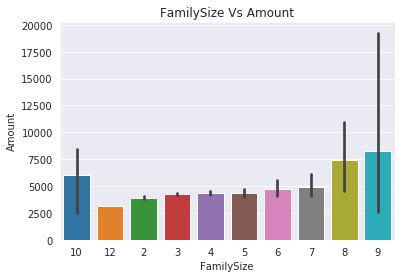

In [20]:
sns.barplot(x = 'FamilySize', y = 'Amount', data=data)
plt.title('FamilySize Vs Amount')

There is no pattern visible from the above graph and amount is almost same across all middle families. Family size with value 9 has a lot of spread to to it.

Scatterplot to check spread of Amount with Distance

In [21]:
fig, ax = plt.subplots()
ax.scatter(x = data['Distance'], y = data['Amount'])
plt.ylabel('Amount', fontsize=13)
plt.xlabel('Distance', fontsize=13)
plt.title('Distance Vs Amount')
plt.show()

Most of the times distance does not impact Amount. For a handfull of customers living nearby tend to spend more.

Scatterplot to check spread of Amount with Duration

In [22]:
fig, ax = plt.subplots()
ax.scatter(x = data['Duration'], y = data['Amount'])
plt.ylabel('Amount', fontsize=13)
plt.xlabel('Duration', fontsize=13)
plt.title('Duration Vs Amount')
plt.show()

Pretty much same as Distance people spending more time in the store does not imply that they will spend more money. But most of the high spenders do stay in the store for longer time

Scatterplot to check spread of Amount with DirectVisits

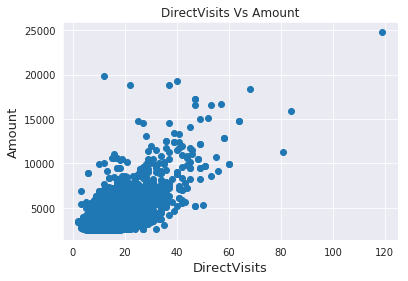

In [23]:
fig, ax = plt.subplots()
ax.scatter(x = data['DirectVisits'], y = data['Amount'])
plt.ylabel('Amount', fontsize=13)
plt.xlabel('DirectVisits', fontsize=13)
plt.title('DirectVisits Vs Amount')
plt.show()

We see a clear pattern that people who have made more visits to the store spend more. More interestingly, the customer with highest amount spent does not look like an outlier. Infact, it looks like the customer will fit the pattern very nicely

Scatterplot to check spread of Amount with OnlineVisits

In [24]:
fig, ax = plt.subplots()
ax.scatter(x = data['OnlineVisits'], y = data['Amount'])
plt.ylabel('Amount', fontsize=13)
plt.xlabel('OnlineVisits', fontsize=13)
plt.title('OnlineVisits Vs Amount')
plt.show()

Here the pattern is even more clear. The distant point looks less and less like an outlier

Scatterplot to check spread of Amount with Quantity

In [25]:
fig, ax = plt.subplots()
ax.scatter(x = data['Quantity'], y = data['Amount'])
plt.ylabel('Amount', fontsize=13)
plt.xlabel('Quantity', fontsize=13)
plt.title('Quantity Vs Amount')
plt.show()

Surprisingly, customers with more quantity are not spending too much. These could mean that they are outliers or that they are purchasing large amount of cheap products. Without a list of products purchased we cannot declare them as outliers we keep these points.
Let's check the NumberofFrequentItems for customers with Quantity > 15000

In [26]:
data.loc[data['Quantity']>15000,:]

Amount FamilySize  Distance  Duration  DirectVisits  OnlineVisits  \
332    12543          5         8       392            36            32   
462     9975          5         9       464            60            49   
883    12543          5         8       392            36            32   
1016    9975          5         9       464            60            49   
2296    6351          3         5       433            37            29   

      Quantity  NumberofFrequentItems TransactionMode   Area Occupation  
332  23746.000                 29.000               2  Area1          2  
462  18728.000                 60.000               2  Area1          2  
883  23746.000                 29.000               2  Area1          2  
1016 18728.000                 60.000               2  Area1          2  
2296 27829.000                 36.000               2  Area1          1

The NumberofFrequentItems is not too high or not too low. We cannot declare these points as Outliers

Scatterplot to check spread of Amount with NumberofFrequentItems

In [27]:
fig, ax = plt.subplots()
ax.scatter(x = data['NumberofFrequentItems'], y = data['Amount'])
plt.ylabel('Amount', fontsize=13)
plt.xlabel('NumberofFrequentItems', fontsize=13)
plt.title('NumberofFrequentItems Vs Amount')
plt.show()

We see a pattern that more NumberofFrequentItems implies more Amount spent. Here also we see that the exterme point is not an outlier.

Checking spread of mean amount across TransactionMode levels

In [28]:
sns.barplot(x = 'TransactionMode', y = 'Amount', data=data)
plt.title('TransactionMode Vs Amount')

Text(0.5,1,'TransactionMode Vs Amount')

TransactionMode 2 gives slightly more revenue

Checking spread of mean amount across Area levels

In [29]:
sns.barplot(x = 'Area', y = 'Amount', data=data)
plt.title('Area Vs Amount')

Text(0.5,1,'Area Vs Amount')

Area 1 gives more slightly more revenue.

Checking spread of mean amount across Occupation levels

Text(0.5,1,'Occupation Vs Amount')

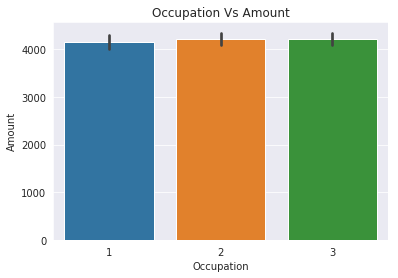

In [30]:
sns.barplot(x = 'Occupation', y = 'Amount', data=data)
plt.title('Occupation Vs Amount')

Clearly, occupation has no impact on amount

Checking distribution of target variable Amount using density plot.
Also plotting the QQ-Plot to check if the target is normal or not


 mu = 4196.12 and sigma = 2059.10



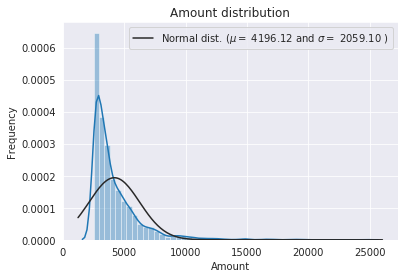

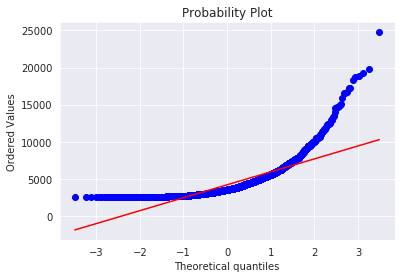

2.9757605285128843


In [31]:
sns.distplot(data['Amount'] , fit=norm);

(mu, sigma) = norm.fit(data['Amount'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Amount distribution')

fig = plt.figure()
res = stats.probplot(data['Amount'], plot=plt)
plt.show()
print(skew(data['Amount']))

The target variable is highly skewed and is not normal at all (skew = 2.9)

This concludes our EDA and we move onto Building the base model

# Model Building

Get dummies for all the categorical data and then drop one of the columns to avoide the dummy variable trap

In [32]:
model_data = pd.get_dummies(data)
dummy_remove = ['FamilySize_10','TransactionMode_1','Area_Area1','Occupation_1']
model_data.drop(dummy_remove,axis=1,inplace=True)
model_data.head()

Amount  Distance  Duration  DirectVisits  OnlineVisits  Quantity  \
0    3125         6       261            11             9   365.000   
1    5298         5       323             9             9   218.000   
2    4375         6       355            11            11  1367.000   
3    9700         7       418            51            41  2947.000   
4    3625         7       290             9             9  1233.000   

   NumberofFrequentItems  FamilySize_12  FamilySize_2  FamilySize_3  \
0                 11.000              0             1             0   
1                  3.000              0             1             0   
2                 11.000              0             1             0   
3                 51.000              0             0             0   
4                  8.000              0             1             0   

   FamilySize_4  FamilySize_5  FamilySize_6  FamilySize_7  FamilySize_8  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             1             0             0             0   
4             0             0             0             0             0   

   FamilySize_9  TransactionMode_2  Area_Area2  Occupation_2  Occupation_3  
0             0                  1           0             1             0  
1             0                  1           0             0             0  
2             0                  1           0             1             0  
3             0                  0           0             0             0  
4             0                  1           0             0             1

Standardize the numeric coluns in data.
Since we are not just spliting the data into train and test but, instead using cross validation we don't need to divide the data before standarizing.

In [33]:
numeric_cols = ['Distance','Duration','DirectVisits','OnlineVisits','Quantity','NumberofFrequentItems']
sc = StandardScaler()
model_data[numeric_cols] = sc.fit_transform(model_data[numeric_cols])
model_data.head()

Amount  Distance  Duration  DirectVisits  OnlineVisits  Quantity  \
0    3125    -0.454    -0.991        -0.654        -0.813    -0.659   
1    5298    -0.790    -0.300        -0.891        -0.813    -0.735   
2    4375    -0.454     0.057        -0.654        -0.538    -0.140   
3    9700    -0.119     0.759         4.081         3.582     0.677   
4    3625    -0.119    -0.668        -0.891        -0.813    -0.210   

   NumberofFrequentItems  FamilySize_12  FamilySize_2  FamilySize_3  \
0                 -0.485              0             1             0   
1                 -1.415              0             1             0   
2                 -0.485              0             1             0   
3                  4.164              0             0             0   
4                 -0.834              0             1             0   

   FamilySize_4  FamilySize_5  FamilySize_6  FamilySize_7  FamilySize_8  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             1             0             0             0   
4             0             0             0             0             0   

   FamilySize_9  TransactionMode_2  Area_Area2  Occupation_2  Occupation_3  
0             0                  1           0             1             0  
1             0                  1           0             0             0  
2             0                  1           0             1             0  
3             0                  0           0             0             0  
4             0                  1           0             0             1

Seperate the Features (independent varaibles) in X and target (dependent variable) in y 

In [34]:
X = model_data.iloc[:,1:]
y = model_data.iloc[:,0]

Make a error dataframe in which we will store the errors for all the models so that we can easily compare the models after building the model.
Also, since we are using cross_validate which does not have RMSE and MAPE as in-built error metrics we make our own custom scorer.

In [35]:
model_errors_cols = ['name','train_rmse','train_rmse_std','train_mape','train_mape_std','test_rmse', 'test_rmse_std','test_mape','test_mape_std','time']
model_errors = pd.DataFrame(columns=model_errors_cols)
scorer = {'rmse' : make_scorer(rmse),
          'mape' : make_scorer(mape)}

Since everytime a model is built and score is calculated we have to add it to the model error dataframe we make a fucntion which we can call after building each model.

In [36]:
def fill_model_error(model_errors, cv_results, model_name):
    ''' Function to add to the error model dataframe
        @params:
            - model_errors: Error dataframe to which new row has to be added.
            - cv_results: Cross Validation Results having train, test RMSE and MAPE along with time taken.
            - model_name: Name of the model fitted
        @returns:
            - Error dataframe with new row added
    '''
    index = model_errors.shape[0]
    model_errors.loc[index, 'name'] = model_name
    model_errors.loc[index, 'time'] = cv_results['fit_time'].mean()
    model_errors.loc[index, 'train_rmse'] = cv_results['train_rmse'].mean()
    model_errors.loc[index, 'train_rmse_std'] = stdev(cv_results['train_rmse'])
    model_errors.loc[index, 'train_mape'] = cv_results['train_mape'].mean()
    model_errors.loc[index, 'train_mape_std'] = stdev(cv_results['train_mape'])
    model_errors.loc[index, 'test_rmse'] = cv_results['test_rmse'].mean()
    model_errors.loc[index, 'test_rmse_std'] = stdev(cv_results['test_rmse'])
    model_errors.loc[index, 'test_mape'] = cv_results['test_mape'].mean()
    model_errors.loc[index, 'test_mape_std'] = stdev(cv_results['test_mape'])
    return model_errors

Finally we make our first model (base model). The reason we make such a basic model is that we now have a benchmark to compare our other models with.

In [37]:
base_model = LinearRegression()
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .7, random_state = 0 )
model_name = "Base Linear Model"
cv_results = model_selection.cross_validate(base_model, X, y, cv  = cv_split, scoring=scorer)
cv_results
model_errors = fill_model_error(model_errors,cv_results,model_name)
model_errors

name train_rmse train_rmse_std train_mape train_mape_std  \
0  Base Linear Model   1065.743         23.676      0.185          0.001   

  test_rmse test_rmse_std test_mape test_mape_std  time  
0  1087.076        58.952     0.187         0.006 0.007

The base model actually does not do too bad and has test MAPE of 18%.

Checking the coefficients and Rsqaured of model fitted 

In [38]:
base_model.fit(X,y)
print("Rsquared for the base model is : ({:.4f})".format(base_model.score(X,y)))
print("Coefficents for the base model are : \n" , base_model.coef_)

Rsquared for the base model is : (0.7310)
Coefficents for the base model are : 
 [ 1.06017766e+00 -5.04480550e+01  2.31221730e+03  1.66050808e+03
  6.26930628e+01 -2.55725175e+03 -2.23114196e+03 -1.31439523e+03
 -1.24621191e+03 -1.32055270e+03 -1.37679015e+03 -1.10324482e+03
 -1.00731875e+03 -6.57489233e+02  4.92422876e+02  2.96889500e+02
  3.00146392e+02  1.79388441e+01 -3.21586326e+01]


Caluclating residuals to check how the errors are behaving.

In [39]:
y_pred = base_model.predict(X)
residuals = y - y_pred

Scatterplot of residuals vs predicted values of y

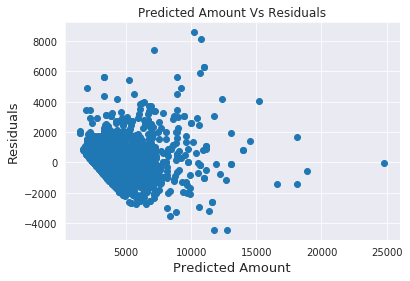

In [40]:
fig, ax = plt.subplots()
ax.scatter(x = y_pred, y = residuals)
plt.ylabel('Residuals', fontsize=13)
plt.xlabel('Predicted Amount', fontsize=13)
plt.title('Predicted Amount Vs Residuals')
plt.show()

We are making more error for mid range amounts. Interestingly for large values of Amount we are making very less error. Therefore we conclude that the extreme values of amount for our data are not outliers.

While we usually only check residuals vs predicted amount only, we have compared residuals with all predictors. This allows us to see how the error is spread across all features giving us insights for feature engineering

Scatterplot of residuals vs Distance

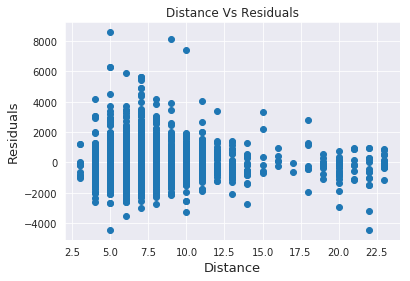

In [41]:
fig, ax = plt.subplots()
ax.scatter(x = data['Distance'], y = residuals)
plt.ylabel('Residuals', fontsize=13)
plt.xlabel('Distance', fontsize=13)
plt.title('Distance Vs Residuals')
plt.show()

There is some sort of pattern where we are making more error for low and high values of distance and less for middle values. 
We can bin the distance column into 3 bins serprating at 10 and 17.

Scatterplot of residuals vs Duration

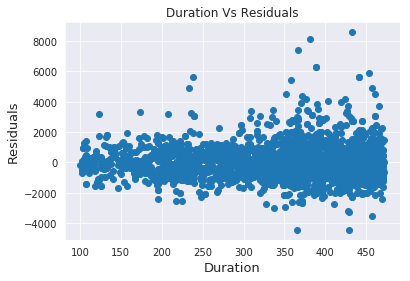

In [42]:
fig, ax = plt.subplots()
ax.scatter(x = data['Duration'], y = residuals)
plt.ylabel('Residuals', fontsize=13)
plt.xlabel('Duration', fontsize=13)
plt.title('Duration Vs Residuals')
plt.show()

Error is ever so slightly increasing with increase in duration. 
Since there is no clear pattern will cut it into 3 bins of equal values

Scatterplot of residuals vs DirectVisits

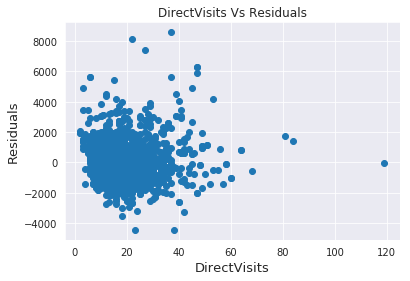

In [43]:
fig, ax = plt.subplots()
ax.scatter(x = data['DirectVisits'], y = residuals)
plt.ylabel('Residuals', fontsize=13)
plt.xlabel('DirectVisits', fontsize=13)
plt.title('DirectVisits Vs Residuals')
plt.show()

Scatterplot of residuals vs OnlineVisits

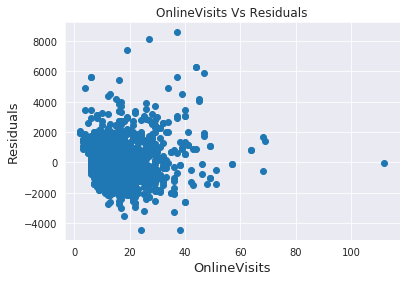

In [44]:
fig, ax = plt.subplots()
ax.scatter(x = data['OnlineVisits'], y = residuals)
plt.ylabel('Residuals', fontsize=13)
plt.xlabel('OnlineVisits', fontsize=13)
plt.title('OnlineVisits Vs Residuals')
plt.show()

Both Direct and Online visits follow almost the same pattern. Here also we see that for higher values of visits we are actually making less error.
We can add the two columns to get Total number of visits.

Scatterplot of residuals vs Quantity

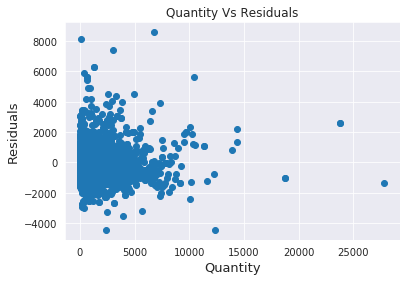

In [45]:
fig, ax = plt.subplots()
ax.scatter(x = data['Quantity'], y = residuals)
plt.ylabel('Residuals', fontsize=13)
plt.xlabel('Quantity', fontsize=13)
plt.title('Quantity Vs Residuals')
plt.show()

There is no pattern to Quantity therefore, we do not get any particular insights for any feature engineering

Scatterplot of residuals vs NumberofFrequentItems

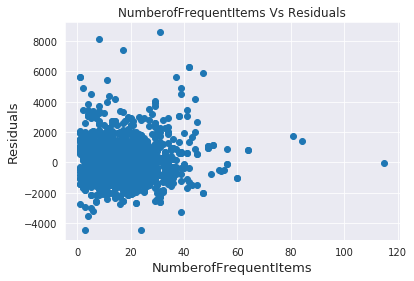

In [46]:
fig, ax = plt.subplots()
ax.scatter(x = data['NumberofFrequentItems'], y = residuals)
plt.ylabel('Residuals', fontsize=13)
plt.xlabel('NumberofFrequentItems', fontsize=13)
plt.title('NumberofFrequentItems Vs Residuals')
plt.show()

There is no pattern to NumberofFrequentItems therefore, we do not get any particular insights for any feature engineering

For categorical data we use bar plots instead of scatterplots

Barplot of residuals across family size

Text(0,0.5,'Residuals')

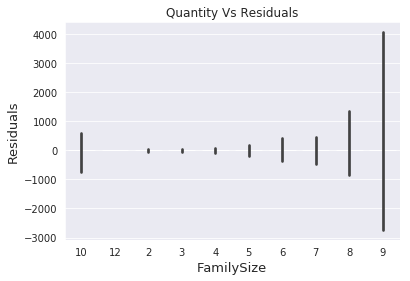

In [47]:
sns.barplot(x = data['FamilySize'], y = residuals)
plt.title('Quantity Vs Residuals')
plt.xlabel('FamilySize',fontsize = 13)
plt.ylabel('Residuals',fontsize = 13)

Very interesting we see that we are making moderate error for middle size family and large error for large families.
Clearly we need to bin them into 3 bins seperated at 4 and 7

Barplot of residuals across TransactionMode

Text(0,0.5,'Residuals')

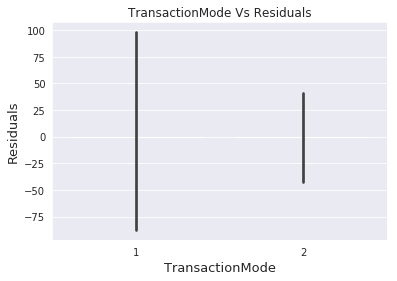

In [48]:
sns.barplot(x = data['TransactionMode'], y = residuals)
plt.title('TransactionMode Vs Residuals')
plt.xlabel('TransactionMode',fontsize = 13)
plt.ylabel('Residuals',fontsize = 13)

We are making more error with Transction mode 1. Coincidently this column is class in-balanced with mode 2 being the heavy category. Either we can make two different models for them or we can try to reduce the class in-balance.
Also notice that the residual scale has changed from range of thousands we are now down to -75 to 75.

Barplot of residuals across Area

Text(0,0.5,'Residuals')

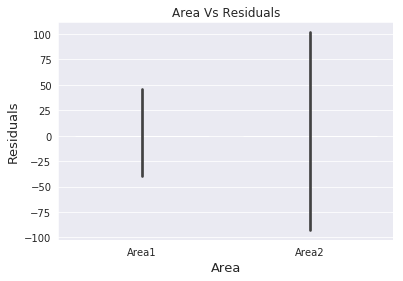

In [49]:
sns.barplot(x = data['Area'], y = residuals)
plt.title('Area Vs Residuals')
plt.xlabel('Area',fontsize = 13)
plt.ylabel('Residuals',fontsize = 13)

We are making more error with Area 2. Agian this column is class in-balanced with Area 1 being the heavy category. Either we can make two different models for them or we can try to reduce the class in-balance.
Again notice that the residual scale has changed from range of thousands we are now down to -75 to 75.

Barplot of residuals across Occupation

Text(0,0.5,'Residuals')

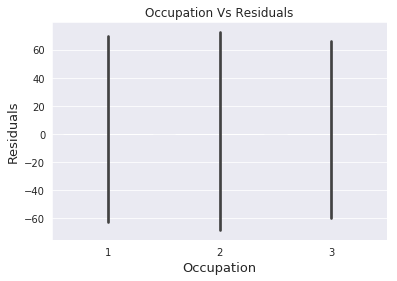

In [50]:
sns.barplot(x = data['Occupation'], y = residuals)
plt.title('Occupation Vs Residuals')
plt.xlabel('Occupation',fontsize = 13)
plt.ylabel('Residuals',fontsize = 13)

There is no difference at all. Especially at that scale. So no changes here as well.

# Feature Enginnering

Get the original data back and perform some of the same basic data manipulation

In [51]:
data = data_copy.copy()
data.drop('PersonID',axis=1,inplace=True)
cat_labels = ['Occupation','TransactionMode']
for label in cat_labels:
    data[label] = data[label].astype('str')
cols = ['Quantity','NumberofFrequentItems']
data[cols] =data[cols].replace({0:np.nan})
data.dropna(inplace=True)
data.head()

Amount  FamilySize  Distance  Duration  DirectVisits  OnlineVisits  \
0    3125           2         6       261            11             9   
1    5298           2         5       323             9             9   
2    4375           2         6       355            11            11   
3    9700           5         7       418            51            41   
4    3625           2         7       290             9             9   

   Quantity  NumberofFrequentItems TransactionMode   Area Occupation  
0   365.000                 11.000               2  Area1          2  
1   218.000                  3.000               2  Area1          1  
2  1367.000                 11.000               2  Area1          2  
3  2947.000                 51.000               1  Area1          1  
4  1233.000                  8.000               2  Area1          3

Bin Family into 3 as decided by the barplot

In [52]:
bin_fam = []
for family in data_copy['FamilySize']:
    if family <= 4:
        bin_fam.append('Low')
    if family > 4 and family <= 7:
        bin_fam.append('Medium')
    if family > 7: 
        bin_fam.append('High')
family_size = pd.Series(bin_fam)
data.FamilySize = family_size
data.head()

Amount FamilySize  Distance  Duration  DirectVisits  OnlineVisits  \
0    3125        Low         6       261            11             9   
1    5298        Low         5       323             9             9   
2    4375        Low         6       355            11            11   
3    9700     Medium         7       418            51            41   
4    3625        Low         7       290             9             9   

   Quantity  NumberofFrequentItems TransactionMode   Area Occupation  
0   365.000                 11.000               2  Area1          2  
1   218.000                  3.000               2  Area1          1  
2  1367.000                 11.000               2  Area1          2  
3  2947.000                 51.000               1  Area1          1  
4  1233.000                  8.000               2  Area1          3

Draw the plot again

Text(0,0.5,'Amount')

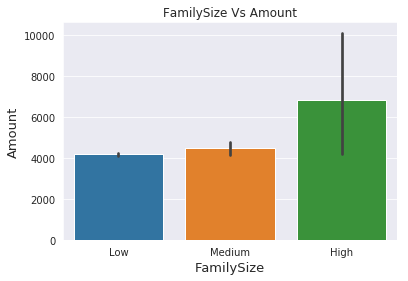

In [53]:
sns.barplot(x = 'FamilySize', y = 'Amount', data=data)
plt.title('FamilySize Vs Amount')
plt.xlabel('FamilySize',fontsize = 13)
plt.ylabel('Amount',fontsize = 13)

Clearly, this gives us better insigths

Bin Duration into 3 equal values bins

In [54]:
data['Duration'] = pd.cut(data['Duration'],3,labels=['Low','Medium','High'])

Draw the plot again

Text(0,0.5,'Amount')

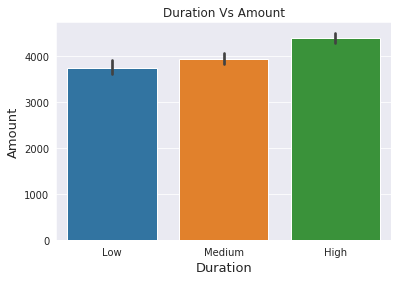

In [55]:
sns.barplot(x = 'Duration', y = 'Amount', data=data)
plt.title('Duration Vs Amount')
plt.xlabel('Duration',fontsize = 13)
plt.ylabel('Amount',fontsize = 13)

Not too much difference, but still better than before!

Bin Distance into 3 as decided by the plot above.

In [56]:
bin_dist = []
for distance in data_copy['Distance']:
    if distance <= 10:
        bin_dist.append('Small')
    if distance > 10 and family <= 17:
        bin_dist.append('Medium')
    if distance > 17: 
        bin_dist.append('Large')
distance = pd.Series(bin_dist)
data.Distance = distance
data.head()

Amount FamilySize Distance Duration  DirectVisits  OnlineVisits  Quantity  \
0    3125        Low    Small   Medium            11             9   365.000   
1    5298        Low    Small   Medium             9             9   218.000   
2    4375        Low    Small     High            11            11  1367.000   
3    9700     Medium    Small     High            51            41  2947.000   
4    3625        Low    Small   Medium             9             9  1233.000   

   NumberofFrequentItems TransactionMode   Area Occupation  
0                 11.000               2  Area1          2  
1                  3.000               2  Area1          1  
2                 11.000               2  Area1          2  
3                 51.000               1  Area1          1  
4                  8.000               2  Area1          3

Make the plot again

Text(0,0.5,'Amount')

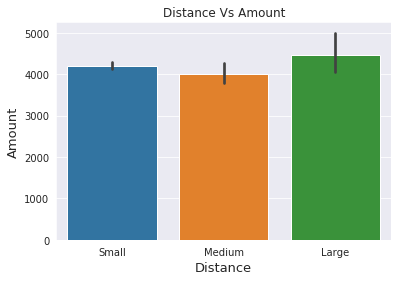

In [57]:
sns.barplot(x = 'Distance', y = 'Amount', data=data)
plt.title('Distance Vs Amount')
plt.xlabel('Distance',fontsize = 13)
plt.ylabel('Amount',fontsize = 13)

At least large has some difference now

Add Direct and Online Visits

In [58]:
data['total_visit'] = data['DirectVisits'] + data['OnlineVisits']

Drop Direct and Online Visits

In [59]:
data.drop(['DirectVisits','OnlineVisits'],inplace=True, axis=1)

Plot the scatterplot

In [60]:
fig, ax = plt.subplots()
ax.scatter(x = data['total_visit'], y = data['Amount'])
plt.ylabel('Amount', fontsize=13)
plt.xlabel('Total No of Visits', fontsize=13)
plt.title('Total Visits vs Amount')
plt.show()

We'll see if the correlation has increased or not

Draw the correlation plot

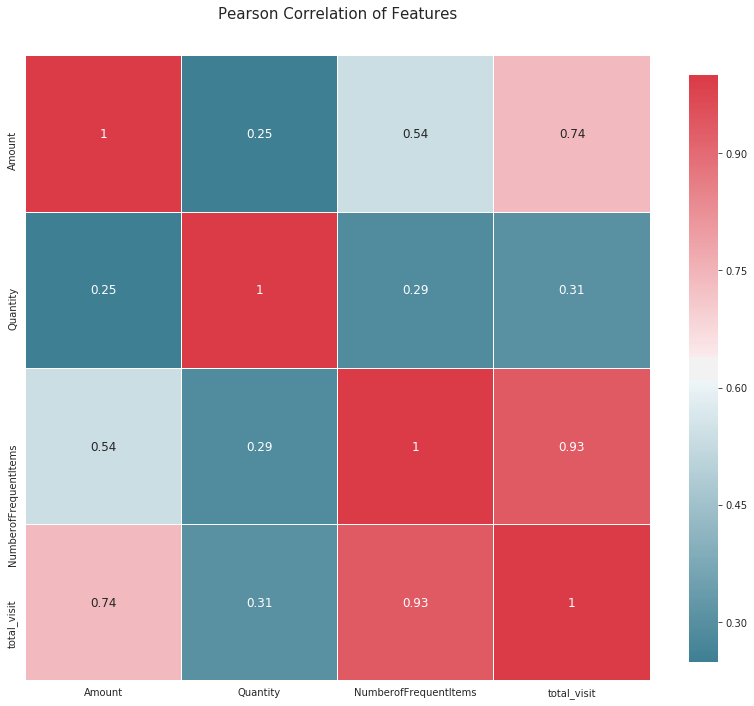

In [61]:
numeric_feats = data.dtypes[data.dtypes != "object"].index
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(data[numeric_feats])

Total visits correlation has not increased too much when compared to Online and Direct. But we can use this so that out model is compact

# Build Models Again

These steps are same as when we first made the models

In [62]:
model_data = pd.get_dummies(data)
model_data.head()
dummy_remove = ['FamilySize_High','Distance_Small','Duration_Low','TransactionMode_1','Area_Area1','Occupation_1']
model_data.drop(dummy_remove,axis=1,inplace=True)
model_data.head()

Amount  Quantity  NumberofFrequentItems  total_visit  FamilySize_Low  \
0    3125   365.000                 11.000           20               1   
1    5298   218.000                  3.000           18               1   
2    4375  1367.000                 11.000           22               1   
3    9700  2947.000                 51.000           92               0   
4    3625  1233.000                  8.000           18               1   

   FamilySize_Medium  Distance_Large  Distance_Medium  Duration_Medium  \
0                  0               0                0                1   
1                  0               0                0                1   
2                  0               0                0                0   
3                  1               0                0                0   
4                  0               0                0                1   

   Duration_High  TransactionMode_2  Area_Area2  Occupation_2  Occupation_3  
0              0                  1           0             1             0  
1              0                  1           0             0             0  
2              1                  1           0             1             0  
3              1                  0           0             0             0  
4              0                  1           0             0             1

In [63]:
numeric_cols = ['Quantity','NumberofFrequentItems','total_visit']
sc = StandardScaler()
model_data[numeric_cols] = sc.fit_transform(model_data[numeric_cols])
model_data.head()

Amount  Quantity  NumberofFrequentItems  total_visit  FamilySize_Low  \
0    3125    -0.659                 -0.485       -0.740               1   
1    5298    -0.735                 -1.415       -0.869               1   
2    4375    -0.140                 -0.485       -0.611               1   
3    9700     0.677                  4.164        3.915               0   
4    3625    -0.210                 -0.834       -0.869               1   

   FamilySize_Medium  Distance_Large  Distance_Medium  Duration_Medium  \
0                  0               0                0                1   
1                  0               0                0                1   
2                  0               0                0                0   
3                  1               0                0                0   
4                  0               0                0                1   

   Duration_High  TransactionMode_2  Area_Area2  Occupation_2  Occupation_3  
0              0                  1           0             1             0  
1              0                  1           0             0             0  
2              1                  1           0             1             0  
3              1                  0           0             0             0  
4              0                  1           0             0             1

In [64]:
X = model_data.iloc[:,1:]
y = model_data.iloc[:,0]

Log Transformation on target to make it linear.

In [65]:
y_transformed = np.log1p(y)

sns.distplot(y_transformed, fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y_transformed)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Amount distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_transformed, plot=plt)
plt.show()

skew(y_transformed)


 mu = 8.26 and sigma = 0.37



1.2018875612023892

Target is still very skewed. 
We'll see if this is better or worse after the model is built

We need to make the scorers again to incorporate that we have now applied log tranformation on the target variable

In [66]:
def mape_inv(y_true, y_pred):
    y_true = np.exp(y_true)
    y_pred = np.exp(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))
def rmse_inv(y_true, y_pred):
    y_true = np.exp(y_true)
    y_pred = np.exp(y_pred)
    return  math.sqrt(mean_squared_error(y_true, y_pred))

In [67]:
score_inv = {'rmse' : make_scorer(rmse_inv),
          'mape' : make_scorer(mape_inv)}

Make model with Log tranformation and feature engineering

In [68]:
base_model_log = LinearRegression()
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .7, random_state = 0 )
model_name = "LM Log and Feature Engineering"
cv_results = model_selection.cross_validate(base_model_log, X, y_transformed, cv  = cv_split, scoring=score_inv)
model_errors = fill_model_error(model_errors,cv_results,model_name)
model_errors

name train_rmse train_rmse_std train_mape  \
0               Base Linear Model   1065.743         23.676      0.185   
1  LM Log and Feature Engineering   2069.563        634.346      0.173   

  train_mape_std test_rmse test_rmse_std test_mape test_mape_std  time  
0          0.001  1087.076        58.952     0.187         0.006 0.007  
1          0.003  2903.009      1850.696     0.175         0.006 0.010

Even though MAPE has decreased RMSE has increased by a lot! Plus there is large standard deviation.
This could be because of feture engineering or the tranformation.
Let's build the next model only using feature engineering

In [69]:
base_model_log = LinearRegression()
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .7, random_state = 0 )
model_name = "LM Feature Engineering"
cv_results = model_selection.cross_validate(base_model_log, X, y, cv  = cv_split, scoring=scorer)
model_errors = fill_model_error(model_errors,cv_results,model_name)
model_errors

name train_rmse train_rmse_std train_mape  \
0               Base Linear Model   1065.743         23.676      0.185   
1  LM Log and Feature Engineering   2069.563        634.346      0.173   
2          LM Feature Engineering   1068.910         23.757      0.186   

  train_mape_std test_rmse test_rmse_std test_mape test_mape_std  time  
0          0.001  1087.076        58.952     0.187         0.006 0.007  
1          0.003  2903.009      1850.696     0.175         0.006 0.010  
2          0.001  1078.583        56.133     0.187         0.004 0.007

The error has come back to previous range. Moreover, it has slightly decreased. Our feature engineering is giving was not worthless!

Let's start making advanced models without log transformation
These models are :
1. Lasso
2. Ridge
3. ElasticNet
4. Decisiontree
5. KNN
6. Randomforest
7. SVM

In [70]:
lasso = make_pipeline(RobustScaler(), Lasso(random_state=1))
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .7, random_state = 0 )
model_name = "Lasso"
cv_results = model_selection.cross_validate(lasso, X, y, cv  = cv_split, scoring=scorer)
model_errors = fill_model_error(model_errors,cv_results,model_name)
model_errors

name train_rmse train_rmse_std train_mape  \
0               Base Linear Model   1065.743         23.676      0.185   
1  LM Log and Feature Engineering   2069.563        634.346      0.173   
2          LM Feature Engineering   1068.910         23.757      0.186   
3                           Lasso   1069.378         23.780      0.186   

  train_mape_std test_rmse test_rmse_std test_mape test_mape_std  time  
0          0.001  1087.076        58.952     0.187         0.006 0.007  
1          0.003  2903.009      1850.696     0.175         0.006 0.010  
2          0.001  1078.583        56.133     0.187         0.004 0.007  
3          0.001  1079.234        57.421     0.186         0.004 0.014

Let's check if lasso has dropped any columns

In [71]:
lasso_coef = Lasso()
lasso_coef.fit(X,y)
print("Number of columns before Lasso : {}".format(X.shape[1]))
print("Number of columns after Lasso : {}".format(len(lasso_coef.coef_)))

Number of columns before Lasso : 13
Number of columns after Lasso : 13


So, Lasso did not remove any columns

In [72]:
ridge = Ridge()
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .7, random_state = 0 )
model_name = "Ridge"
cv_results = model_selection.cross_validate(ridge, X, y, cv  = cv_split, scoring=scorer)
model_errors = fill_model_error(model_errors,cv_results,model_name)
model_errors

name train_rmse train_rmse_std train_mape  \
0               Base Linear Model   1065.743         23.676      0.185   
1  LM Log and Feature Engineering   2069.563        634.346      0.173   
2          LM Feature Engineering   1068.910         23.757      0.186   
3                           Lasso   1069.378         23.780      0.186   
4                           Ridge   1069.011         23.784      0.186   

  train_mape_std test_rmse test_rmse_std test_mape test_mape_std  time  
0          0.001  1087.076        58.952     0.187         0.006 0.007  
1          0.003  2903.009      1850.696     0.175         0.006 0.010  
2          0.001  1078.583        56.133     0.187         0.004 0.007  
3          0.001  1079.234        57.421     0.186         0.004 0.014  
4          0.001  1078.695        57.045     0.186         0.004 0.003

In [73]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .7, random_state = 0 )
model_name = "ENet"
cv_results = model_selection.cross_validate(ENet, X, y, cv  = cv_split, scoring=scorer)
model_errors = fill_model_error(model_errors,cv_results,model_name)
model_errors

name train_rmse train_rmse_std train_mape  \
0               Base Linear Model   1065.743         23.676      0.185   
1  LM Log and Feature Engineering   2069.563        634.346      0.173   
2          LM Feature Engineering   1068.910         23.757      0.186   
3                           Lasso   1069.378         23.780      0.186   
4                           Ridge   1069.011         23.784      0.186   
5                            ENet   1068.912         23.757      0.186   

  train_mape_std test_rmse test_rmse_std test_mape test_mape_std  time  
0          0.001  1087.076        58.952     0.187         0.006 0.007  
1          0.003  2903.009      1850.696     0.175         0.006 0.010  
2          0.001  1078.583        56.133     0.187         0.004 0.007  
3          0.001  1079.234        57.421     0.186         0.004 0.014  
4          0.001  1078.695        57.045     0.186         0.004 0.003  
5          0.001  1078.581        56.237     0.186         0.004 0.039

In [74]:
dt = DecisionTreeRegressor()
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .7, random_state = 0 )
model_name = "dt"
cv_results = model_selection.cross_validate(dt, X, y, cv  = cv_split, scoring=scorer)
model_errors = fill_model_error(model_errors,cv_results,model_name)
model_errors

name train_rmse train_rmse_std train_mape  \
0               Base Linear Model   1065.743         23.676      0.185   
1  LM Log and Feature Engineering   2069.563        634.346      0.173   
2          LM Feature Engineering   1068.910         23.757      0.186   
3                           Lasso   1069.378         23.780      0.186   
4                           Ridge   1069.011         23.784      0.186   
5                            ENet   1068.912         23.757      0.186   
6                              dt      0.393          0.507      0.000   

  train_mape_std test_rmse test_rmse_std test_mape test_mape_std  time  
0          0.001  1087.076        58.952     0.187         0.006 0.007  
1          0.003  2903.009      1850.696     0.175         0.006 0.010  
2          0.001  1078.583        56.133     0.187         0.004 0.007  
3          0.001  1079.234        57.421     0.186         0.004 0.014  
4          0.001  1078.695        57.045     0.186         0.004 0.003  
5          0.001  1078.581        56.237     0.186         0.004 0.039  
6          0.000  1378.556        88.503     0.191         0.007 0.013

In [75]:
knn = KNeighborsRegressor()
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .7, random_state = 0 )
model_name = "knn"
cv_results = model_selection.cross_validate(knn, X, y, cv  = cv_split, scoring=scorer)
model_errors = fill_model_error(model_errors,cv_results,model_name)
model_errors

name train_rmse train_rmse_std train_mape  \
0               Base Linear Model   1065.743         23.676      0.185   
1  LM Log and Feature Engineering   2069.563        634.346      0.173   
2          LM Feature Engineering   1068.910         23.757      0.186   
3                           Lasso   1069.378         23.780      0.186   
4                           Ridge   1069.011         23.784      0.186   
5                            ENet   1068.912         23.757      0.186   
6                              dt      0.393          0.507      0.000   
7                             knn   1073.479         29.276      0.162   

  train_mape_std test_rmse test_rmse_std test_mape test_mape_std  time  
0          0.001  1087.076        58.952     0.187         0.006 0.007  
1          0.003  2903.009      1850.696     0.175         0.006 0.010  
2          0.001  1078.583        56.133     0.187         0.004 0.007  
3          0.001  1079.234        57.421     0.186         0.004 0.014  
4          0.001  1078.695        57.045     0.186         0.004 0.003  
5          0.001  1078.581        56.237     0.186         0.004 0.039  
6          0.000  1378.556        88.503     0.191         0.007 0.013  
7          0.003  1388.433        98.519     0.201         0.004 0.003

In [76]:
rf = RandomForestRegressor()
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .7, random_state = 0 )
model_name = "rf"
cv_results = model_selection.cross_validate(rf, X, y, cv  = cv_split, scoring=scorer)
model_errors = fill_model_error(model_errors,cv_results,model_name)
model_errors

name train_rmse train_rmse_std train_mape  \
0               Base Linear Model   1065.743         23.676      0.185   
1  LM Log and Feature Engineering   2069.563        634.346      0.173   
2          LM Feature Engineering   1068.910         23.757      0.186   
3                           Lasso   1069.378         23.780      0.186   
4                           Ridge   1069.011         23.784      0.186   
5                            ENet   1068.912         23.757      0.186   
6                              dt      0.393          0.507      0.000   
7                             knn   1073.479         29.276      0.162   
8                              rf    471.031         19.337      0.067   

  train_mape_std test_rmse test_rmse_std test_mape test_mape_std  time  
0          0.001  1087.076        58.952     0.187         0.006 0.007  
1          0.003  2903.009      1850.696     0.175         0.006 0.010  
2          0.001  1078.583        56.133     0.187         0.004 0.007  
3          0.001  1079.234        57.421     0.186         0.004 0.014  
4          0.001  1078.695        57.045     0.186         0.004 0.003  
5          0.001  1078.581        56.237     0.186         0.004 0.039  
6          0.000  1378.556        88.503     0.191         0.007 0.013  
7          0.003  1388.433        98.519     0.201         0.004 0.003  
8          0.002  1153.613        63.266     0.172         0.005 0.061

In [77]:
svm = svm.SVR()
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .7, random_state = 0 )
model_name = "svm"
cv_results = model_selection.cross_validate(svm, X, y, cv  = cv_split, scoring=scorer)
model_errors = fill_model_error(model_errors,cv_results,model_name)
model_errors

name train_rmse train_rmse_std train_mape  \
0               Base Linear Model   1065.743         23.676      0.185   
1  LM Log and Feature Engineering   2069.563        634.346      0.173   
2          LM Feature Engineering   1068.910         23.757      0.186   
3                           Lasso   1069.378         23.780      0.186   
4                           Ridge   1069.011         23.784      0.186   
5                            ENet   1068.912         23.757      0.186   
6                              dt      0.393          0.507      0.000   
7                             knn   1073.479         29.276      0.162   
8                              rf    471.031         19.337      0.067   
9                             svm   2104.094         75.671      0.241   

  train_mape_std test_rmse test_rmse_std test_mape test_mape_std  time  
0          0.001  1087.076        58.952     0.187         0.006 0.007  
1          0.003  2903.009      1850.696     0.175         0.006 0.010  
2          0.001  1078.583        56.133     0.187         0.004 0.007  
3          0.001  1079.234        57.421     0.186         0.004 0.014  
4          0.001  1078.695        57.045     0.186         0.004 0.003  
5          0.001  1078.581        56.237     0.186         0.004 0.039  
6          0.000  1378.556        88.503     0.191         0.007 0.013  
7          0.003  1388.433        98.519     0.201         0.004 0.003  
8          0.002  1153.613        63.266     0.172         0.005 0.061  
9          0.003  2155.945       175.472     0.243         0.006 0.326

In the final Error Dataframe we see that most of the models are very close ot each other. 
The best one seems to be the ENet model as it has low error and low standard deviation which mean that this model is more consistant while making errors. Granted that there is not much difference between Ridge, Lasso and ENet we still say ENet performed best.

Plot the test errors in a barplot

In [78]:
sns.barplot(x='test_rmse', y = 'name', data = model_errors, color = 'm')
plt.title('Model vs Test RMSE score \n')
plt.xlabel('Test RMSE')
plt.ylabel('Model')

Text(0,0.5,'Model')

Since we have selected Ridge as our best model lets get the coefficiets for the Ridge model

In [79]:
ENet_coef = ElasticNet()
ENet_coef.fit(X,y)
print("Coefficients of ENet Model are : ", ENet_coef.coef_)

Coefficients of ENet Model are :  [ 1.29286859e+02  1.62679294e+02  8.82246289e+02 -9.69148298e+00
  0.00000000e+00  1.64866273e+01 -1.72772877e+01 -4.82678915e+00
  1.16683377e+01  8.68336245e+01 -3.43756901e+01  1.60309132e+01
 -7.37501327e-01]


Looks like ENet has dropped one column.

# Conclusions
We conclude following points:
1. Imputation without checking the error metric might be harmful.
2. EDA is very important as it gives us an overview on how out data is behaving.
3. Base model actually turned out to be one of the better models.
4. The residuals of base model allowed us to gain insights for feature engineering which decreased the error.
5. Transformations do not gaurantee less error.

## Final Remarks
The above analysis is by no means a comprehensive analysis as we could still do a lot. Including BoxCox transformation, some other combinations of features and hyper parameter tuning.